In [29]:
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import pandas as pd
import numpy as np
#事实证明我的模型没问题，不过我的数据预处理有问题，有非常严重的过拟合，难道是因为经过的处理的数据较复杂，我的这个模型太简单
#所以有过拟合问题
#可是我的预处理数据真的复杂吗？

In [30]:
#导入 取了对数的label

df_train = pd.read_csv('./input/processed_train_logged.csv')
df_test = pd.read_csv('./input/processed_test_logged.csv')

#导入没有取对数的label

# df_train = pd.read_csv('./input/processed_train_without_log.csv')
# df_test = pd.read_csv('./input/processed_test_without_log.csv')

In [20]:
# 用Provided data 和 我的模型来做
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']))
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())
                                                            / (x.std()))
all_X = pd.get_dummies(all_X, dummy_na=True)
all_X = all_X.fillna(all_X.mean())
num_train = train.shape[0]

train_data = nd.array(all_X[:num_train].as_matrix())
test_data = nd.array(all_X[num_train:].as_matrix())
label = nd.array(np.log1p(train.SalePrice.as_matrix()))
test_id = test['Id']

In [ ]:
#save provided data
x_train = all_X.iloc[0:num_train,:]
x_test = all_X.iloc[num_train:,:]
x_train['label'] = train.SalePrice
x_train.to_csv('./input/provided_train.csv',index=False)
x_test.to_csv('./input/provided_test.csv',index=False)

In [ ]:
df_test.head()

In [31]:
#处理输入数据, without Id
target = 'label'
not_features = ['label']
feat_names = df_train.columns[[item not in not_features for item in df_train.columns ]]

train_data = nd.array(df_train[feat_names].values)
label = nd.array(df_train['label'].values)
test_data = nd.array(df_test[feat_names].values)
test_id = df_test['Id']

In [32]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(l2loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [33]:
#使用gluon内置的dataloader

batch_size = 100
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [34]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

In [35]:
#用一个多层感知机吧
import mxnet.gluon.nn as nn
import mxnet

net = get_net()

# training
epoches = 100
global_train_loss = []
l2loss = gluon.loss.L2Loss()
def train_test(net,verbose_epoches,train_data,train_label,learning_rate,wd,test_data= None,test_label = None):
    #kfold
    #net 需要重新初始化
    net.collect_params().initialize(force_reinit=True)
    dataset_train = gluon.data.ArrayDataset(train_data, train_label)
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd': wd})
    train_loss = []
    if test_data is not None:
        test_loss = []
    for epoch in range(epoches):
        
        rmse = 0.0
        for data,label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = l2loss(output,label)
            loss.backward()
            trainer.step(batch_size)
            cur_train_loss = get_rmse_log(net,train_data,train_label)
        
        
        train_loss.append(cur_train_loss)
        if test_data is not None:
            cur_test_loss = get_rmse_log(net,test_data,test_label)
            test_loss.append(cur_test_loss)
        if(epoch>verbose_epoches):
            print("Epoch:%d, training rmse:%f "%(epoch,cur_train_loss))
            if test_data is not None:
                print("Epoch:%d,  testing rmse:%f"%(epoch,cur_test_loss))
        
    plt.plot(train_loss)
    plt.legend(['train'])
    if test_data is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if test_data is not None:
        return cur_train_loss,cur_test_loss
    else:
        return cur_train_loss
    
    



In [44]:
learning_rate = 0.01
wd  = 0

Epoch:91, training rmse:0.011070 
Epoch:91,  testing rmse:0.015511
Epoch:92, training rmse:0.010124 
Epoch:92,  testing rmse:0.014837
Epoch:93, training rmse:0.010358 
Epoch:93,  testing rmse:0.014356
Epoch:94, training rmse:0.010213 
Epoch:94,  testing rmse:0.014273
Epoch:95, training rmse:0.010258 
Epoch:95,  testing rmse:0.014733
Epoch:96, training rmse:0.010138 
Epoch:96,  testing rmse:0.013989
Epoch:97, training rmse:0.009818 
Epoch:97,  testing rmse:0.014157
Epoch:98, training rmse:0.010843 
Epoch:98,  testing rmse:0.014687
Epoch:99, training rmse:0.010119 
Epoch:99,  testing rmse:0.013661


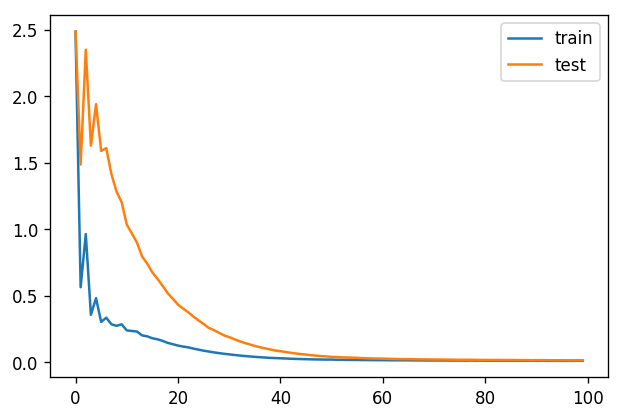

Epoch:91, training rmse:0.008102 
Epoch:91,  testing rmse:0.013232
Epoch:92, training rmse:0.008028 
Epoch:92,  testing rmse:0.013144
Epoch:93, training rmse:0.008000 
Epoch:93,  testing rmse:0.013120
Epoch:94, training rmse:0.008284 
Epoch:94,  testing rmse:0.013300
Epoch:95, training rmse:0.008025 
Epoch:95,  testing rmse:0.013071
Epoch:96, training rmse:0.008037 
Epoch:96,  testing rmse:0.013169
Epoch:97, training rmse:0.008759 
Epoch:97,  testing rmse:0.013320
Epoch:98, training rmse:0.008154 
Epoch:98,  testing rmse:0.013194
Epoch:99, training rmse:0.008447 
Epoch:99,  testing rmse:0.013182


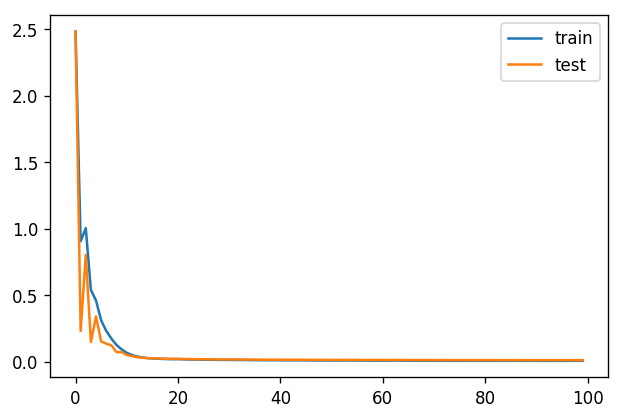

Epoch:91, training rmse:0.009192 
Epoch:91,  testing rmse:0.013778
Epoch:92, training rmse:0.009067 
Epoch:92,  testing rmse:0.013823
Epoch:93, training rmse:0.009034 
Epoch:93,  testing rmse:0.013836
Epoch:94, training rmse:0.009027 
Epoch:94,  testing rmse:0.013732
Epoch:95, training rmse:0.009063 
Epoch:95,  testing rmse:0.013693
Epoch:96, training rmse:0.008964 
Epoch:96,  testing rmse:0.013665
Epoch:97, training rmse:0.008925 
Epoch:97,  testing rmse:0.013729
Epoch:98, training rmse:0.008956 
Epoch:98,  testing rmse:0.014020
Epoch:99, training rmse:0.008927 
Epoch:99,  testing rmse:0.013938


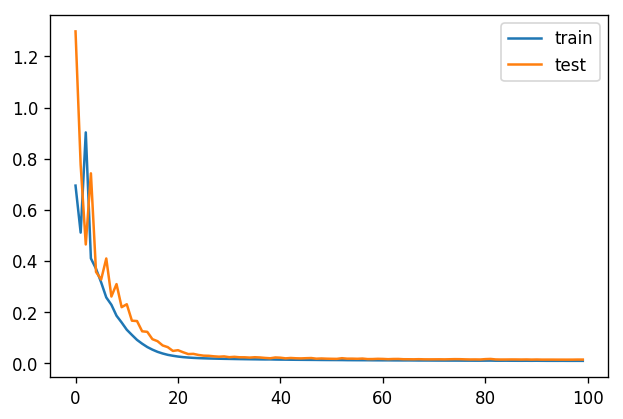

In [45]:
#write k-fold codes
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
for train_index,test_index in kf.split(train_data):
    train_index= nd.array(train_index)
    test_index = nd.array(test_index)
    train_feat,train_label = nd.take(train_data,train_index),nd.take(label,train_index)
    valid_feat,valid_label = nd.take(train_data,test_index),nd.take(label,test_index)
    train_rmse,valid_rmse = train_test(net,90,train_feat,train_label,learning_rate,wd,valid_feat,valid_label)
#     print(train_rmse)
#     print(valid_rmse)

In [40]:
# predict results
submission = pd.read_csv('./input/sample_submission.csv')

In [41]:
submission.head()
test_id = submission['Id']

In [46]:
def learn_predict(train_data,train_label,test_data,learning_rate,wd):
    net = get_net()
    verbose_epoches = 90
    train_test(net,verbose_epoches,train_data,train_label,learning_rate,wd)
    pred = np.expm1(net(test_data).asnumpy().ravel())
    print(pred.shape)
    mysubmission = pd.DataFrame({'Id':test_id,'SalePrice':pred})
    mysubmission.to_csv('./input/mysubmission_v9.csv',index= False)
    

Epoch:91, training rmse:0.008571 
Epoch:92, training rmse:0.009759 
Epoch:93, training rmse:0.008420 
Epoch:94, training rmse:0.008458 
Epoch:95, training rmse:0.008397 
Epoch:96, training rmse:0.008223 
Epoch:97, training rmse:0.008183 
Epoch:98, training rmse:0.008853 
Epoch:99, training rmse:0.009176 


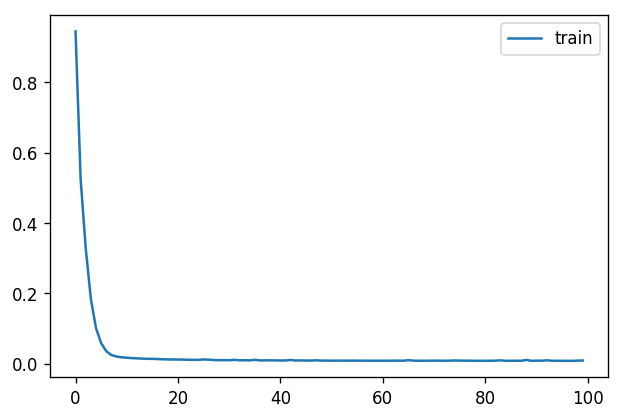

(1459,)


In [47]:
learn_predict(train_data,label,test_data,learning_rate,wd)